In [2]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


In [3]:
# Preprocessing
# Load the data
yulu_data_set = pd.read_csv('yulu_bike_sharing_dataset.csv')

# Split the 'datetime' column into 'date' and 'time' columns
yulu_data_set[['date', 'time']] = yulu_data_set['datetime'].str.split(' ', expand=True)
yulu_data_set = yulu_data_set.drop(columns=['datetime'])

# Specify the names of categorical and numerical columns
categorical_columns = ['season', 'holiday', 'workingday', 'weather']  # Update with your actual categorical columns
numerical_columns = ['temp', 'atemp', 'humidity', 'windspeed']  # Update with your actual numerical columns
target_column = 'count'  # Update if your target variable is named differently

# Creating a column transformer for handling both numerical and categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])


In [4]:
# Outlier detection
# Set the threshold for outlier detection
threshold = 2

# Calculate the z-scores for each data point in the 'count' column
z_scores = stats.zscore(yulu_data_set['count'])

# Filter the data: only keep data points where the z-score is less than the threshold and greater than the negative threshold
data_without_outliers = yulu_data_set[(z_scores < threshold) & (z_scores > -threshold)]

# Print the number of outliers removed
print(f"Outliers removed: {len(yulu_data_set) - len(data_without_outliers)}")

Outliers removed: 589


In [5]:
# Train Test split
# Separating the target variable
X = data_without_outliers.drop(columns=[target_column])
y = data_without_outliers[target_column]

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


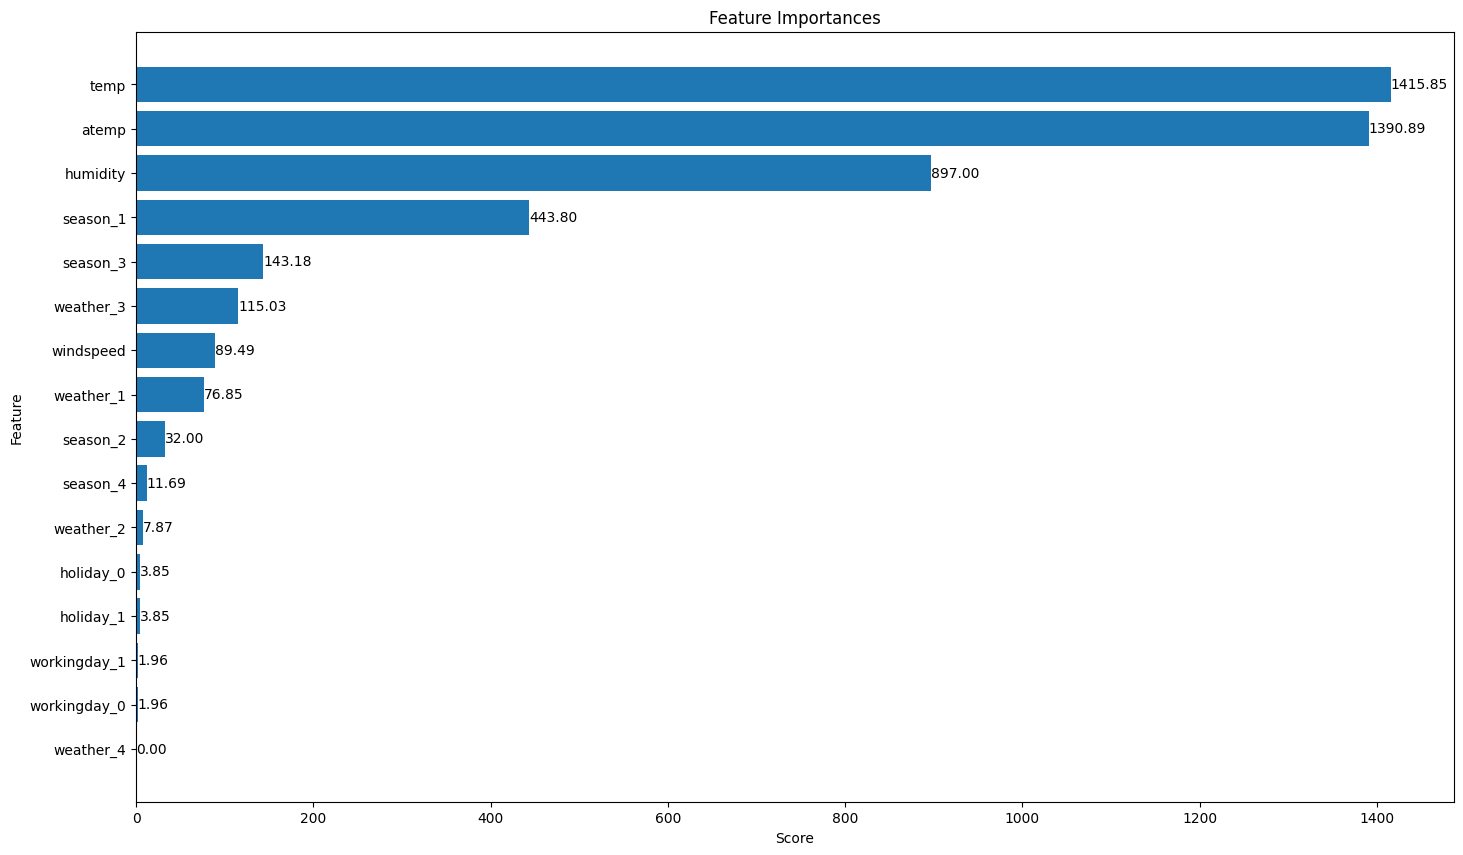

In [6]:
# Feature selection
# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Apply SelectKBest with f_regression
k = 10  # Number of top features to select, adjust as needed
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_transformed, y_train)

# Get feature names
num_features = numerical_columns
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_features = list(num_features) + list(cat_features)

# Get the scores of the features
feature_scores = selector.scores_

# Create a DataFrame for visualization
feature_scores_df = pd.DataFrame({'Feature': all_features, 'Score': feature_scores})

# Sort the DataFrame by score
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Plot the feature importances with individual scores
plt.figure(figsize=(17, 10))
bars = plt.barh(feature_scores_df['Feature'], feature_scores_df['Score'])
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()

# Add the scores as text on the bars
for bar, score in zip(bars, feature_scores_df['Score']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.2f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.show()

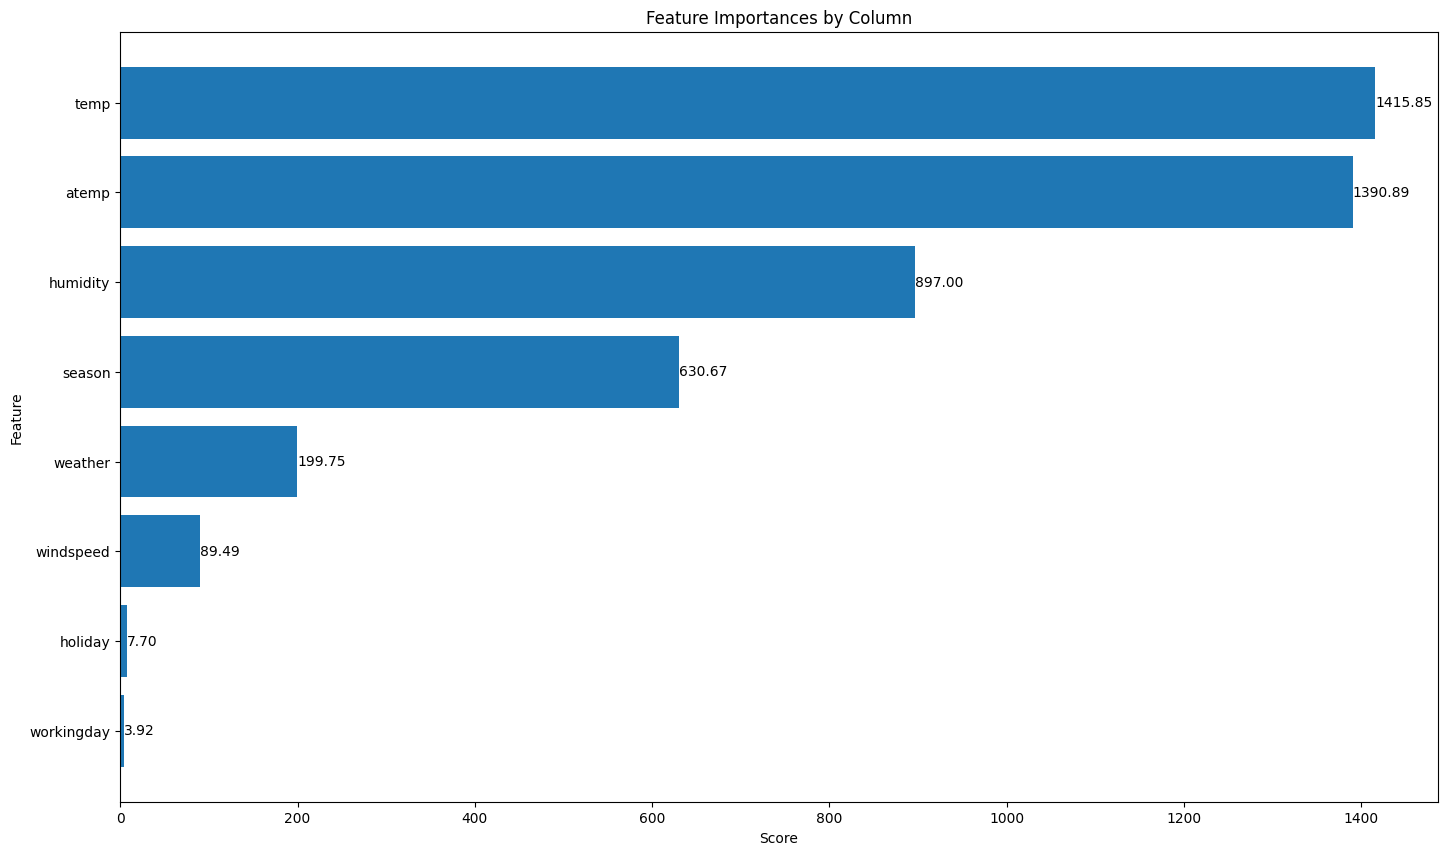

In [7]:
# Feature selection by column
# Aggregate the scores for the original categorical columns
categorical_scores = {}
for feature in cat_features:
    original_col = feature.split('_')[0]
    if original_col in categorical_scores:
        categorical_scores[original_col] += feature_scores[all_features.index(feature)]
    else:
        categorical_scores[original_col] = feature_scores[all_features.index(feature)]

# Combine numerical and aggregated categorical scores
final_feature_scores = {feature: score for feature, score in zip(num_features, feature_scores[:len(num_features)])}
final_feature_scores.update(categorical_scores)

# Convert to DataFrame for plotting
final_feature_scores_df = pd.DataFrame(list(final_feature_scores.items()), columns=['Feature', 'Score'])
final_feature_scores_df = final_feature_scores_df.sort_values(by='Score', ascending=False)

# Plot the feature importances by column with individual scores
plt.figure(figsize=(17, 10))
bars = plt.barh(final_feature_scores_df['Feature'], final_feature_scores_df['Score'])
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature Importances by Column')
plt.gca().invert_yaxis()

# Add the scores as text on the bars
for bar, score in zip(bars, final_feature_scores_df['Score']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.2f}', 
             va='center', ha='left', fontsize=10, color='black')

plt.show()

In [9]:
# Define the range of k values
k_values = [5, 10, 15, 20, 25, 30]  # Adjust these values based on your feature count and preference

# Hyperparameter tuning for Linear Regression including k
# Creating a pipeline with preprocessing and Linear Regression
linear_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_regression)),
    ('regressor', LinearRegression())
])

# Define parameter grid for Linear Regression including k
param_grid_linear = {
    'selector__k': k_values
}

# Use GridSearchCV for hyperparameter tuning
grid_search_linear = GridSearchCV(linear_model, param_grid_linear, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_linear.fit(X_train, y_train)

# Best parameters and best score
print("Linear Regression Best Parameters:", grid_search_linear.best_params_)
print("Linear Regression Best Cross-validated MSE:", -grid_search_linear.best_score_)

# Fit the best model on training data
best_linear_model = grid_search_linear.best_estimator_
best_linear_model.fit(X_train, y_train)

# Predictions
y_pred_linear = best_linear_model.predict(X_test)

# Metrics
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Linear Regression Mean Squared Error (MSE):", mse_linear)
print("Linear Regression Mean Absolute Error (MAE):", mae_linear)
print("Linear Regression R-squared:", r2_linear)


C:\Users\marga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\marga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\marga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\marga\AppData

Linear Regression Best Parameters: {'selector__k': 10}
Linear Regression Best Cross-validated MSE: 14589.391903175405
Linear Regression Mean Squared Error (MSE): 14190.08747991306
Linear Regression Mean Absolute Error (MAE): 93.52072915678671
Linear Regression R-squared: 0.28845438543310187


In [ ]:
# Hyperparameter tuning for RandomForestRegressor
# Creating a pipeline with preprocessing and Random Forest regressor
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_regression, k=k)),
    ('regressor', RandomForestRegressor())
])

# Define parameter grid for RandomForest
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Random Forest Best Parameters:", grid_search.best_params_)
print("Random Forest Best Cross-validated MSE:", -grid_search.best_score_)

# Fit the best model on training data
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = best_rf_model.predict(X_test)

# Metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Mean Squared Error (MSE):", mse_rf)
print("Random Forest Mean Absolute Error (MAE):", mae_rf)
print("Random Forest R-squared:", r2_rf)

## KNN Regressor

In [10]:
from sklearn.neighbors import KNeighborsRegressor

# Preprocessing, feature selection, and Model Training (KNeighborsRegressor)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('select_k_best', SelectKBest(score_func=f_regression)),
    ('regressor', KNeighborsRegressor())
])

# Define the grid of hyperparameters to search
parameters = {
    'select_k_best__k': k_values,
    'regressor__n_neighbors' : [3, 5, 8, 10]
}

# Instantiating GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Predict
y_pred = grid_search.predict(X_test)

# Print performance metrics
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

C:\Users\marga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\marga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\marga\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\marga\AppDa

Mean Squared Error (MSE): 13246.130708737863
Mean Absolute Error (MAE): 88.28563106796116
R-squared: 0.33578801193971974
